# ANN assisted TPS on capped alanine dipeptide 2
In this notebook you will learn
- how to perform input importance analyses for models with transformed atomistic coordinates, i.e. how to find which are the important ANN inputs and how to relate them to atomistic coordinates
- how to create visualizizations of the transitions colored by gradient

This notebook uses files created in `1_setup_and_TPS.ipynb`, please do this notebook first.

In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling as paths

Using TensorFlow backend.


In [3]:
# change to the working directory of choice
# same as for the first notebook
wdir = '/homeloc/scratch/hejung/arcd_scratch/ala/'
#wdir = None
if wdir is not None:
    os.chdir(wdir)

In [4]:
storage = paths.Storage('ala_HB_TPS.nc', 'a')

In [5]:
# get the sampler, attach the hook and run for 1 step to repopulate the trainset and load the model
sampler = storage.pathsimulators[0]
sampler.restart_at_step(storage.steps[-1], storage=storage)

trainhook = arcd.ops.TrainingHook(None, None, 100)
sampler.attach_hook(trainhook)

sampler.run(1)

Working on Monte Carlo cycle number 1002
Starting simulation...
Working on first step


/homeloc/scratch/hejung/conda-envs/arcd_devel/lib/python3.6/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


DONE! Completed 1002 Monte Carlo cycles.


## HIPR analysis
We will have a look at the most important inputs and which atoms contribute to them.

In [6]:
hipr = arcd.analysis.HIPRanalysis(trainhook.model, trainhook.trainset)

In [7]:
final_hipr_losses = hipr.do_hipr()

In [8]:
final_hipr_losses_plus = hipr.do_hipr_plus()

In [9]:
# lets load the model after 500 MCsteps to compare
from arcd.base.rcmodel import RCModel
fname = storage.abspath + '_RCmodel_at_step500.pckl'
state, cls = RCModel.load_state(fname, storage)
state = cls.fix_state(state)
model_at_step500 = cls.set_state(state)

In [10]:
# use the complete trainset for HIPR
# this includes point the ANN has never trained on but makes it comparable to the previous HIPR
hipr_at_step500 = arcd.analysis.HIPRanalysis(model_at_step500, trainhook.trainset)

step500_hipr_losses = hipr_at_step500.do_hipr()
step500_hipr_losses_plus = hipr_at_step500.do_hipr_plus()

Reference loss:  0.5318849262839068

coordinate:  ('cos', [6, 8, 14, 15])
with associated loss:  1.0222091827088011

coordinate:  ('sin', [6, 8, 14, 15])
with associated loss:  0.5665803623770526

coordinate:  ('cos', [1, 4, 6, 8])
with associated loss:  0.5388207342334373

coordinate:  ('sin', [8, 14, 16, 18])
with associated loss:  0.5386478797166409

coordinate:  ('sin', [1, 4, 6, 8])
with associated loss:  0.5351947312345523


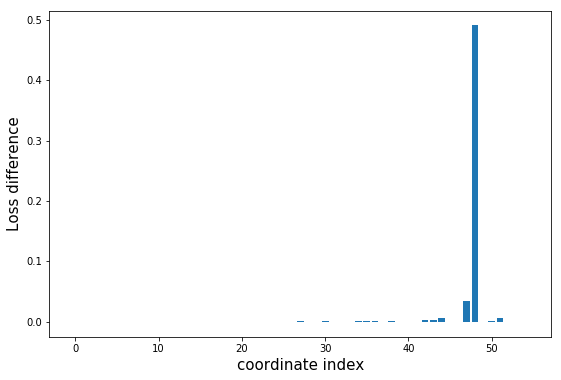

In [11]:
final_loss_diff = final_hipr_losses[:-1] - final_hipr_losses[-1]

plt.bar(np.arange(len(final_loss_diff)), final_loss_diff)
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

# get the associated coordinates for the maximally important inputs
max_idx = np.argsort(final_loss_diff)[::-1]

# this bit below only works for IC only
# figuring out how to get the info for SF CVs is left as an excersise to the reader :)
ic_parms = trainhook.model.descriptor_transform.kwargs['ic_parms']


print('Reference loss: ', final_hipr_losses[-1])
for idx in max_idx[:5]:
    # this little helper function gets you the involved atoms given the input index and the inputparameters to the CV of question
    # there is similar functions for the symmetry functions @ arcd.coords.symmetry.get_involved
    print()
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', final_hipr_losses[idx])

Reference loss:  0.5410692020804583

coordinate:  ('cos', [6, 8, 14, 15])
with associated loss:  1.028923017916803

coordinate:  ('sin', [6, 8, 14, 15])
with associated loss:  0.5620001094307966

coordinate:  ('cos', [1, 4, 6, 8])
with associated loss:  0.5549061560107325

coordinate:  ('cos', [0, 1, 4, 5])
with associated loss:  0.5476359209376657

coordinate:  ('sin', [1, 4, 6, 8])
with associated loss:  0.5457021648536423


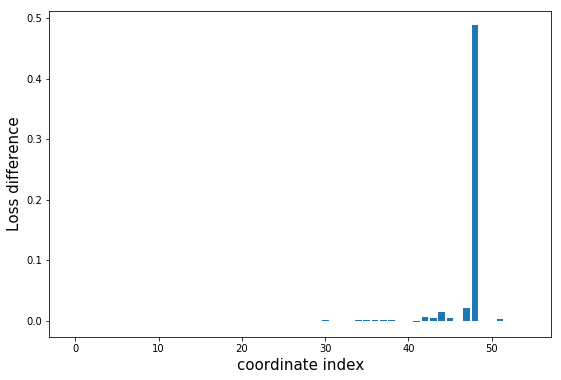

In [13]:
# same for the model after 500 steps
step500_loss_diff = step500_hipr_losses[:-1] - step500_hipr_losses[-1]

plt.bar(np.arange(len(step500_loss_diff)), step500_loss_diff, label='after step 100')
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

max_idx = np.argsort(step500_loss_diff)[::-1]
print('Reference loss: ', step500_hipr_losses[-1])
for idx in max_idx[:5]:
    print()
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', step500_hipr_losses[idx])

## Now we know that the dihedral between the atoms 6, 8, 14 and 15 seems to be important...what are these atoms?

In [16]:
# lets get a snapshot from trajectory, such that we can ask its topology object for the atom names
snap = storage.snapshots[-1]
topol = snap.topology.mdtraj

for at in [6, 8, 14, 15, 16]:
    print('atom: ', topol.atom(at), ' with index: ', at)

atom:  ALA2-N  with index:  6
atom:  ALA2-CA  with index:  8
atom:  ALA2-C  with index:  14
atom:  ALA2-O  with index:  15
atom:  NME3-N  with index:  16


It is a dihedral which is equivalent to psi (atoms 6, 8, 14 and 16) since atom 15 and atom 16 are always in the same plane, they are the O and the N of a peptide bond.

## Can we get a more intuitive feeling for what is happening?
### Lets make a movie of a transition colored by gradient of the learned reaction coordinate!

In [17]:
# get some TPs from the last steps of the storage
tras = []
for step in storage.steps[-50:]:
    if step.change.canonical.accepted:
        tras.append(step.change.canonical.trials[0].trajectory)

In [19]:
# instantiate the movie maker
gmovie = arcd.analysis.GradientMovieMaker(trainhook.model, trainhook.model.descriptor_transform, topol)

In [20]:
# lets choose a trajectory that is not too long to save some time
# (especially important if using symmetry functions)
[len(t) for t in tras]

[42, 42, 95, 60, 71, 33, 47, 64, 36, 70, 74, 47, 40, 94, 108]

In [22]:
# Note: works only for internal coordinates only
# choose the atoms we want to calculate gradients for
# just take all the ala atoms, as they are the only ones that can contribute if using internal coordinates only
atoms = topol.select('not resname HOH')

In [23]:
# this will write out two pdb trajectories with the gradient info in the Bfactors
# one with gradient magnitudes normalized per frame and one with just the gradient magnitudes
gmovie.color_by_gradient(tras[0], 'ala_movie_0.pdb', atom_indices=atoms)

## look at the movie in VMD
Unfortunately just loading the trajectory will not work, since VMD reads only the Bfactors of the first frame, the way to get the movie is:
1. start VMD
2. `source arcd/examples/resources/pdbbfactor.tcl` in the VMD TK console
3. `pdbbfactor $OUTFILENAME` loads the trajectory and writes the Bfactors of every frame into the VMD user field for every frame
4. choose color by user and be amazed :)